# Importing Libraries

In [1]:
from diff_weighted_fields import Grid1D, PowerSpectrum, GaussianFieldGenerator1D, Zeldovich1D
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.random import PRNGKey, split
import jax
import numpy as np
from getdist import MCSamples, plots

#grid setup
L = 4000
N = 1024
dk     = 10  #units of kf 
kmin   = 2  #units of kf
R_clip = 2  #units of cell size
kmax   =0.5 #units of kNyq

#define the field and gaussian generator
grid = Grid1D((N,), L, R_clip = R_clip, dk =dk, kmax = kmax , kmin =kmin)
mesh = Grid1D((N//2,), L, R_clip = R_clip, dk =dk, kmax = kmax , kmin =kmin)

def PK(k,theta, threshold = 0.001):
    A,R,n = theta
    _p = A*(k*R)**n*jnp.exp(-(k*R)**2)
    sig = jnp.max(_p)
    return _p + sig* threshold

Using clipping smoothing with R_clip = 2 cells (physical = 7.8125); k_clip = 8.042e-01
kmin: 0.0031415926535897933
kmax: 0.4021238684654236
dk: 0.015707963267948967
Using clipping smoothing with R_clip = 2 cells (physical = 15.625); k_clip = 4.021e-01
kmin: 0.0031415926535897933
kmax: 0.2010619342327118
dk: 0.015707963267948967


In [2]:
#white noise used to generate the field
keys = split(PRNGKey(2),300)
noise = jnp.array([grid.generate_hermitian_noise(x) for x in keys])

# Defining main functions 

In [3]:
#gaussian and zeldovich field generators
gen = GaussianFieldGenerator1D(grid, PK)
zel = Zeldovich1D(gen, mesh, scheme = 'cic')

We start by studying the displacement vector:

In [4]:
#fid params
A = 2.
R = 4*grid.H[0]
n = 2.
D = 1 #growth factor

def max_growth_factor_no_shell_crossing(psi: jnp.ndarray, H: float) -> float:
    dpsi_dq = jnp.diff(psi) / H
    min_grad = jnp.min(dpsi_dq)
    return -1.0 / min_grad

psi_q = jnp.array([zel.make_realization(D,[A,R,n],x, displacement=True) for x in noise])
max_D = jnp.array([max_growth_factor_no_shell_crossing(psi, grid.H[0]) for psi in psi_q])
min_max_D = jnp.min(max_D)
print(min_max_D)

1.6688706


Text(0, 0.5, '$\\delta$')

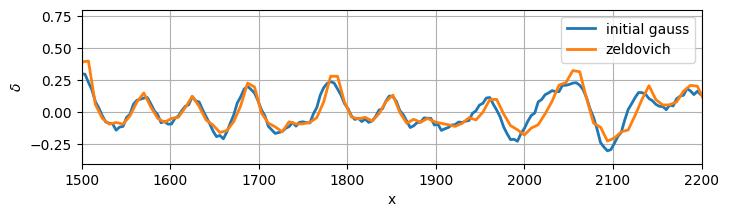

In [5]:
D = 1.6

#generate the field in fourier space and take ifft
gauss = gen.make_realization_from_noise((A,R,n),noise[0])
gauss.compute_ifft()

#zel are generated originally in fourier
zel = zel.make_realization(D,[A,R,n],noise[0])

plt.figure(figsize = (8,2))
plt.plot(gauss.grid.q, gauss.delta, lw =2, label = 'initial gauss')
plt.plot(zel.grid.q,zel.delta/D, lw = 2, label = 'zeldovich')
plt.xlim((1500,2200))
plt.ylim((-0.4,0.8))
plt.grid()
plt.legend()
plt.xlabel('x')
plt.ylabel(r'$\delta$')

In [6]:
def _plin(theta,noise):
    gauss = gen.make_realization_from_noise(theta,noise)
    gauss.compute_ifft()
    return PowerSpectrum(gauss, gauss)

def plin_samples(theta):
    # Compute the power‐spectrum for each noise realization, then average
    ps = jax.vmap(lambda ε: _plin(theta, ε), in_axes=0)(noise)   # (N_real, P_len)
    return ps

def plin(theta):
    # Compute the power‐spectrum for each noise realization, then average
    ps = jax.vmap(lambda ε: _plin(theta, ε), in_axes=0)(noise)   # (N_real, P_len)
    return jnp.mean(ps, axis=0) 

def cov(theta):
    # Gather the raw PS realizations to form a sample covariance
    ps = jax.vmap(lambda ε: _plin(theta, ε), in_axes=0)(noise)   # (N_real, P_len)
    return jnp.cov(ps.T)   

# JIT‐compile both:
plin_jit   = jax.jit(plin)
cov_jit    = jax.jit(cov)
jac_plin   = jax.jit(jax.jacfwd(plin)) 

def ParamCov(theta):
    theta = jnp.asarray(theta)
    J = jac_plin(theta)
    C_inv = jnp.linalg.inv(cov_jit(theta))
    return jnp.linalg.inv(J.T @ (C_inv @ J))

In [7]:
param_cov = ParamCov((A,R,n))

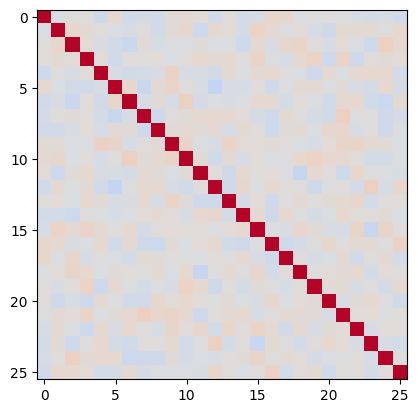

In [8]:
def correlation_from_covariance(covariance_matrix):
    diag = jnp.sqrt(jnp.diag(covariance_matrix))
    outer_diag = jnp.outer(diag, diag)
    correlation_matrix = covariance_matrix / outer_diag
    correlation_matrix = jnp.nan_to_num(correlation_matrix)
    return correlation_matrix

correlation_matrix = correlation_from_covariance(cov_jit((A, R, n)))
plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)

In [ ]:
#draw samples from the multivariate normal distribution and make triangle plot using getdist
import getdist
import getdist.plots as gplt
import numpy as np
from getdist import MCSamples
samples = np.random.multivariate_normal([A,R,n], param_cov, size=1000)
samples = MCSamples(samples=samples, names=['A', 'R', 'n'])
g = gplt.getSubplotPlotter()
g.triangle_plot(samples, filled=True, contour_levels=[0.68, 0.95])

In [10]:
def likelihood(A, R, n, data):
    theory = plin((A, R, n))
    #the ensemble average only agree when cov indep. of parameters
    inv_cov = jax.lax.stop_gradient(jnp.linalg.inv(cov((A, R, n))))
    diff = theory - data
    return 0.5 * jnp.dot(diff, jnp.dot(inv_cov, diff))

data = plin_samples((A,R,n))

In [11]:
hess_jit = jax.hessian(likelihood, argnums=(0, 1, 2))
_ = hess_jit(A, R, n, data[0])

hess_sample = []
for i in range(200):
    hess_matrix = jnp.array(hess_jit(A, R, n, data[i]))
    hess_sample.append(hess_matrix)

In [12]:
fisher_sample = jnp.array([jnp.linalg.inv(h) for h in hess_sample])

In [ ]:
plt.hist(fisher_sample[:,0,0],bins = 30)
plt.vlines(param_cov[0,0], 0, 100, color='red', label='Fisher from covariance')

# Marked Likelihood

In [89]:
def _plin_mark(D,A,R,n,R_smooth,C,noise):
    zel = Zeldovich1D(gen, mesh, scheme = 'cic')
    zel = zel.make_realization(D, (A,R,n), noise)
    zel.compute_fft()
    zel.ComputeBasis(R_smooth)
    f = zel.WeightedChild(C)
    return PowerSpectrum(f, f)

def plin_mark(theta, D, R_smooth,C):
    A, R, n = theta[0], theta[1], theta[2]
    # vmap over the last axis of `noise`.  Each noise[i] is one random seed.
    # _plin_mark returns a length-P vector for each realization.
    ps_samples = jax.vmap(
        lambda ε: _plin_mark(D, A, R, n, R_smooth, C, ε),
        in_axes=0,
    )(noise)                  # shape: (N_realizations, P_len)

    return jnp.mean(ps_samples, axis=0)   # shape: (P_len,)

def cov_mark(theta, D, R_smooth,C):
    """
    Return the P_len×P_len covariance matrix of the raw PS
    samples at (A,R,n)=theta, averaged over noise.
    """
    A, R, n = theta[0], theta[1], theta[2]
    ps_samples = jax.vmap(
        lambda ε: _plin_mark(D, A, R, n, R_smooth, C, ε),
        in_axes=0,
    )(noise)  # (N_realizations, P_len)

    # Cov of shape (P_len, P_len)
    return jnp.cov(ps_samples.T)

jac_plin_mark   = jax.jacfwd(plin_mark)

def ParamCov_marked(theta,D, R_smooth,C):
    theta = jnp.asarray(theta)
    J = jac_plin_mark(theta,D, R_smooth,C)
    C_inv = jnp.linalg.inv(cov_mark(theta,D, R_smooth,C))
    return jnp.linalg.inv(J.T @ (C_inv @ J))

def FoM_marked(theta,D,R_smooth,C):
    return jnp.linalg.det(ParamCov_marked(theta,D, R_smooth,C))

# Marked posteriors for varying D
A = 2.0
R = 4*grid.H[0]
n = 2.0

/var/folders/f8/984tm4nj4h53x1yjrnpd76bw0000gn/T/ipykernel_13021/1095408066.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  marked_samples = np.random.multivariate_normal([A, R, n], marked_cov, size=10000)


[[ 27.880852   -7.7213774   4.371844 ]
 [ -7.721378    7.20093   -14.340851 ]
 [  4.3718495 -14.340849   45.395596 ]]
Removed no burn in


/var/folders/f8/984tm4nj4h53x1yjrnpd76bw0000gn/T/ipykernel_13021/1095408066.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  marked_samples = np.random.multivariate_normal([A, R, n], marked_cov, size=10000)


[[ 27.640646   -7.6297636   4.0130334]
 [ -7.629763    7.211447  -14.132575 ]
 [  4.0130353 -14.132572   44.607    ]]
Removed no burn in


/var/folders/f8/984tm4nj4h53x1yjrnpd76bw0000gn/T/ipykernel_13021/1095408066.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  marked_samples = np.random.multivariate_normal([A, R, n], marked_cov, size=10000)


[[25.636742   -5.5397773  -0.17478138]
 [-5.5397754   4.783322   -9.622124  ]
 [-0.17478912 -9.622121   36.693172  ]]
Removed no burn in


/var/folders/f8/984tm4nj4h53x1yjrnpd76bw0000gn/T/ipykernel_13021/1095408066.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  marked_samples = np.random.multivariate_normal([A, R, n], marked_cov, size=10000)


[[22.868446  -3.7338252 -2.6749926]
 [-3.7338252  3.1874173 -7.276435 ]
 [-2.6750011 -7.276435  32.926117 ]]
Removed no burn in


/var/folders/f8/984tm4nj4h53x1yjrnpd76bw0000gn/T/ipykernel_13021/1095408066.py:10: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  marked_samples = np.random.multivariate_normal([A, R, n], marked_cov, size=10000)


[[21.220009  -2.5817502 -4.6770334]
 [-2.5817504  2.2081485 -5.748974 ]
 [-4.6770315 -5.7489753 30.53686  ]]
Removed no burn in


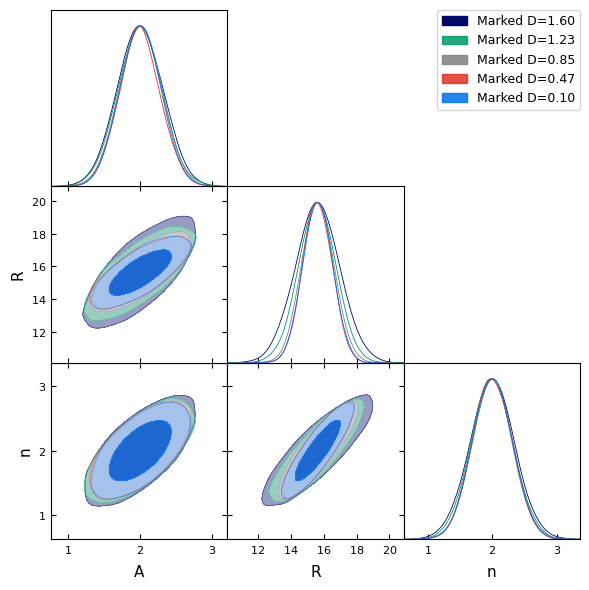

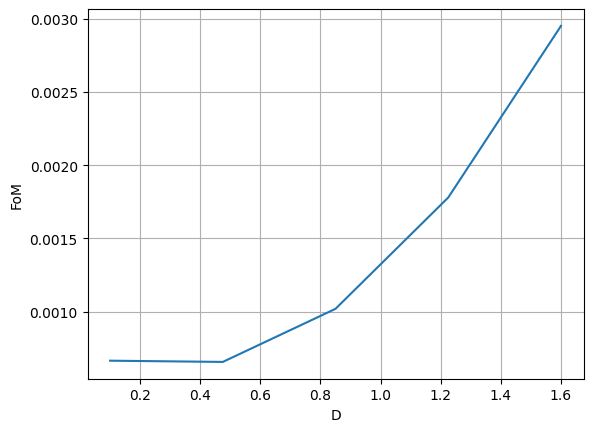

In [90]:
Ds = jnp.linspace(0.1, 1.6, 5)
R_smooth = 2*grid.H[0]
C = jnp.array([1,0,0,0])
marked_posteriors = []
FoM_0 = []
for d in Ds:
    marked_cov = ParamCov_marked((A,R,n),d, R_smooth,C)
    FoM_0.append(jnp.linalg.det(marked_cov))

    marked_samples = np.random.multivariate_normal([A, R, n], marked_cov, size=10000)
    print(jnp.linalg.inv(marked_cov))
    marked_posteriors.append(MCSamples(samples=marked_samples, names=['A', 'R', 'n']))

# Combine all posteriors into a single corner plot
g = plots.getSubplotPlotter()
g.triangle_plot(
    marked_posteriors[::-1],
    filled=True,
    contour_levels=[0.95],
    legend_labels=[f'Marked D={D_val:.2f}' for D_val in Ds][::-1]+['Linear'],
)

plt.figure()
plt.plot(Ds,FoM_0)
plt.xlabel('D')
plt.ylabel('FoM')
plt.grid()
del(g)
del(marked_posteriors)
del(marked_samples)

In [107]:
R_smooth = 2*mesh.H
D = 1
FoM_marked_C_vec = jax.jit(jax.vmap(FoM_marked,in_axes=(None,None,None,0)))
_ = FoM_marked_C_vec((A,R,n),D,R_smooth,jnp.array([[1,0,0,0]]))

Nx = 5
Ny = 5
x_min, x_max = -2.0, 2.0
y_min, y_max = -2.0, 2.0

x_vec = jnp.linspace(x_min, x_max, Nx)
y_vec = jnp.linspace(y_min, y_max, Ny)

# --- (3) build a meshgrid and flatten it ---
# X, Y each have shape (Ny, Nx)
X, Y = jnp.meshgrid(x_vec, y_vec, indexing='xy')

# Now flatten:
#   xs_flat, ys_flat each shape (Ny*Nx,)
xs_flat = X.ravel()
ys_flat = Y.ravel()

# Build a 2D array of C‐vectors, shape (Ny*Nx, 4):
# each row = [ 1, x_i, y_i, 0 ]
ones_flat = jnp.ones_like(xs_flat)
zeros_flat = jnp.zeros_like(xs_flat)
C_flat = jnp.stack([ones_flat/5, xs_flat, ys_flat, zeros_flat], axis=1)  # shape (Ny*Nx, 4)

In [116]:
res = FoM_marked_C_vec((A,R,n),D,R_smooth,C_flat)
res.block_until_ready()

Array([0.04517983, 0.0662221 , 0.01359723, 0.00132589, 0.00311814,
       0.0348693 , 0.03025462, 0.00161015, 0.00243726, 0.00475028,
       0.02506759, 0.00559397, 0.00130506, 0.00474706, 0.00706925,
       0.01548281, 0.00058235, 0.00900902, 0.00887813, 0.01021324,
       0.00620485, 0.00390448, 0.04448134, 0.01549789, 0.01431657],      dtype=float32)

In [70]:
res = jax.device_get(res.reshape((Ny, Nx)))